# Stock Trading with Recurrent Reinforcement Learning (RRL)

## Context on RRL 

Recurrent reinforcement learning (RRL) was first introduced for training neural network trading systems in 1996. "Recurrent" means that previous output is fed into the model as a part of input. It was soon extended to trading in a FX market.

*The RRL technique has been found to be a successful machine learning technique for building financial trading systems.*

What is the difference between "recurrent reinforcement learning" and normal "reinforcement learning" (like Q-Learning algorithm)?

The RRL approach differs clearly from dynamic programming and reinforcement algorithms such as TD-learning and Q-learning, which attempt to estimate a value function for the control problem.

The RRL framework allows to create the simple and elegant problem representation, avoids Bellman's curse of dimensionality and offers compelling advantages in efficiency:

**RRL produces real valued actions (portfolio weights) naturally without resorting to the discretization method in the Q-learning**.

RRL has more stable performance compared to the Q-learning when **exposed to noisy datasets**. Q-learning algorithm is more sensitive to the value function selection (perhaps) due to the recursive property of dynamic optimization, while RRL algorithm is more flexible in choosing objective function and saving computational time.

With RRL, trading systems can be optimized by maximizing performance functions, U(), such as "profit" (return after transaction costs), "wealth", utility functions of wealth or risk-adjusted performance ratios like the "sharpe ratio".

[Stack Overflow Source ](https://stats.stackexchange.com/questions/57244/what-is-recurrent-reinforcement-learning)

## Comparison on Reinforcement Learning (RL) vs Supervised and Unsupervised Learning

[Surbhi's Blog Post](https://www.aitude.com/supervised-vs-unsupervised-vs-reinforcement/#:~:text=Principal%20Component%20Analysis-,Reinforcement%20Learning,a%20variety%20of%20learning%20algorithms.)

1.   Supervised Learning deals with two main tasks Regression and Classification. Unsupervised Learning deals with clustering and associative rule mining problems. Whereas Reinforcement Learning deals with exploitation or exploration, Markov’s decision processes, Policy Learning, Deep Learning and value learning.
2.   Supervised Learning works with the labelled data and here the output data patterns are known to the system. But, the unsupervised learning deals with unlabeled data where the output is based on the collection of perceptions. Whereas in Reinforcement Learning Markov’s Decision process- the agent interacts with the environment in discrete steps.
3.   Supervised learning maps labelled data to known output. Whereas, Unsupervised Learning explore patterns and predict the output. Reinforcement Learning follows a trial and error method.
4.   Supervised learning maps labelled data to known output. Whereas, Unsupervised Learning explore patterns and predict the output. Reinforcement Learning follows a trial and error method.

To sum up, in Supervised Learning, the goal is to generate formula based on input and output values. In Unsupervised Learning, we find an association between input values and group them. In Reinforcement Learning an agent learn through delayed feedback by interacting with the environment.

**This might work better in a much volatile environement, an alternative method would be using LSTM with Locally Weighted Regression as a signal generator for stock pullbacks**





## Literature Review

The main basis of this code comes from Teddy Koker's blog on his eloquent yet simple strategy, https://teddykoker.com/2019/06/trading-with-reinforcement-learning-in-python-part-ii-application, so please check it out! It makes the implementation much easier to follow; also check out his other articles, all very impressive. 


This notebook will use the **Sharpe Ratio** to maximise the reward function. The purpose of this notebook is to create a strategy with a high Sharpe ratio when tested on out-of-sample data.


For additional readings, refer to this [research paper](http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf) by Molina from Stanford. She dives deeper into the mathematical formulation behind the utility function and optimisation method. Some of us might be familiar with Gradient Descent which is a technique to minimize the cost function however for RL we will be using **Gradient Ascent** instead to maximize our Sharpe ratio. 

## Sharpe Ratio

The Sharpe ratio is a commonly used indicator to measure the risk adjusted performance of an investment over time. Assuming a risk-free rate of 0, the formula for computing Sharpe ratio is simply the mean returns of the investment divided by the standard deviation of the returns. This can be written as:

$$S _T = {A \over \sqrt{B - A^2}}$$

where $A={1\over T}\sum\limits _{t=1}^{T}R _t$, and $B={1\over T}\sum\limits _{t=1}^{T}R _t^2$

This can be coded in Python like so:

In [ ]:
def sharpe_ratio(rets): # mean returns over standard deviation of the returns
    return rets.mean() / rets.std()

## Trader Function

We know that we will use the Sharpe ratio as our reward function, but how will we know when to trade? We will use the following function to determine our position, $F$, at time $t$:

$$F _t = \tanh(\theta^T x _t)$$

This function will generate a value between 0 and 1, which will tell us what percentage of the portfolio should buy the asset. $\theta$, like in the [last post](https://teddykoker.com/2019/05/trading-with-reinforcement-learning-in-python-part-i-gradient-ascent/), will be the parameters we will optimize using gradient ascent, and $x_t$ will be the input vector at time $t$. For this post, we will assign the input vector as $x_t = [1, r_{t - M}, ... , r_t, F_{t - 1}] $, where $r_t$ is the percent change between the asset at time $t$ and $t - 1$, and $M$ is the number of time series inputs. This means that at every time step, the model will be fed its last position and a series of historical price changes that it can use to calculate its next position. We can calculate all of the positions given price series `x`, and `theta` with the following Python function:

In [ ]:
import numpy as np

# theta is our input parameters in this case the slope of our line

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

## Calculating Returns

Now that we know what our position will be at each time step, we can calculate our returns $R$ at each time step using the following formula:

$$R _t = F _{t-1}r _t - \delta | F _t - F _{t - 1}| $$

In this case $\delta$ is our transaction cost rate. We can code this as a function in Python like so:

In [ ]:
def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

These returns can then be used to calculate our Sharpe ratio.

# Gradient Ascent

## Determining the Gradient

In order to perform gradient ascent, we must compute the derivative of the Sharpe ratio with respect to theta, or ${dS _T}\over{d\theta}$ Using the chain rule and the above formulas we can write it as:

$${{dS _T}\over{d\theta}} = \sum\limits_{t=1}^{T} ( {{dS _T}\over{dA}}{{dA}\over{dR _t}} + {{dS _T}\over{dB}}{{dB}\over{dR _t}}) \cdot ({{dR _t}\over{dF _t}}{{dF}\over{d\theta}} + {{dR _t}\over{dF _{t-1}}}{{dF _{t-1}}\over{d\theta}})$$

*For all of the steps to compute the above derivative as well as the partial derivatives, see Gabriel Molina's paper, [Stock Trading with Recurrent Reinforcement Learning (RRL)](http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf).*

We can compute this derivative in our `gradient` function:

In [ ]:
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    rets = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(rets)
    B = np.mean(np.square(rets))
    S = A / np.sqrt(B - A ** 2)

    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

## Training

Now that we have our gradient function, we can optimize our parameters using gradient ascent. Like the last post, we will update our $\theta$ each epoch using $\theta = \theta + \alpha{dS _T \over d\theta}$, where $\alpha$ is our learning rate.

In [ ]:
def train(x, epochs=500, M=5, commission=0.0025, learning_rate = 0.1):
    theta = np.ones(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe
    
    
    print("finished training")
    return theta, sharpes

# Tiny RL - Testing on Stock Tickers

## Load Data

Now that we have our model, let's test it using historical $BABA data. 
Let's load it in:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount('/content/drive',force_remount=True)
root_path = 'gdrive/My Drive/2021 Capstone/34 Tickers/BABA/Hourly/' 


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dir = "/content/gdrive/MyDrive/2021 Capstone/34 Tickers/BABA/Hourly"
path = f'{dir}/*.csv'

In [ ]:
import glob
files = glob.glob(path)
for f in files:
  print(f)

/content/gdrive/MyDrive/2021 Capstone/34 Tickers/BABA/Hourly/BABA_2014.csv
/content/gdrive/MyDrive/2021 Capstone/34 Tickers/BABA/Hourly/BABA_2015.csv
/content/gdrive/MyDrive/2021 Capstone/34 Tickers/BABA/Hourly/BABA_2016.csv
/content/gdrive/MyDrive/2021 Capstone/34 Tickers/BABA/Hourly/BABA_2018.csv
/content/gdrive/MyDrive/2021 Capstone/34 Tickers/BABA/Hourly/BABA_2017.csv
/content/gdrive/MyDrive/2021 Capstone/34 Tickers/BABA/Hourly/BABA_2020.csv
/content/gdrive/MyDrive/2021 Capstone/34 Tickers/BABA/Hourly/BABA_2019.csv
/content/gdrive/MyDrive/2021 Capstone/34 Tickers/BABA/Hourly/BABA_2021.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame()
for yr in files:
  df = pd.concat([pd.read_csv(yr, parse_dates=['time'], index_col=1), df])
df.sort_index(inplace=True)
df.drop(['symbol'], axis=1, inplace=True)

cols = [3,7,10,12,14,16,18,20,22]
df.drop(df.columns[cols],axis=1,inplace=True)

In [ ]:
## Verify Data has loaded 
print(f"No. of data points: {len(df)}")
print(f"Start of raw data: {df.index[0]}")
print(f"End of raw data: {df.index[-1]}")


No. of data points: 11372
Start of raw data: 2014-09-19 10:00:00
End of raw data: 2021-03-12 16:00:00




```
# This is formatted as code
```

## Data Preprocessing

In [ ]:
start = '2015-03'
end = '2021-03'

df = df.loc[start:end].copy()

print("After filtering:")
print(f"No. of data points: {len(df)}")
print(f"Start of raw data: {df.index[0]}")
print(f"End of raw data: {df.index[-1]}")

After filtering:
No. of data points: 10601
Start of raw data: 2015-03-02 10:00:00
End of raw data: 2021-03-12 16:00:00


In [ ]:
df['prev_high'] = df['high'].shift(1)
df['fod_high'] = df['high'] - df['high'].shift(1)
df['spread'] = (df['high'] - df['low'])
df['return'] = df['close'] / df['open'] - 1
df.drop(['close', 'low', 'open'], axis=1, inplace=True)
# Because of first-order difference, we have to discard the very first entry.
df = df.iloc[1:].copy()

In [ ]:
def dfplot(input_df, size=(20,10)):
  # plot each column
  plt.figure(figsize=size)
  for cnt, feature in enumerate(input_df.columns):
    plt.subplot(len(input_df.columns), 1, cnt+1)
    plt.plot(input_df[feature])
    plt.title(feature, y=0.5, loc='right')
  plt.show()



In [ ]:
df.head()

,high,volume,prev_high,fod_high,spread,return
time,,,,,,
2015-03-02 11:00:00,84.75,1857564.0,85.02,-0.27,0.45,-0.002248
2015-03-02 12:00:00,84.64,1561488.0,84.75,-0.11,0.58,-0.001186
2015-03-02 13:00:00,84.39,1097501.0,84.64,-0.25,0.35,0.001069
2015-03-02 14:00:00,84.43,1363524.0,84.39,0.04,0.48,-0.003440
2015-03-02 15:00:00,84.02,1110209.0,84.43,-0.41,0.20,-0.001309


In [ ]:
df.tail()

,high,volume,prev_high,fod_high,spread,return
time,,,,,,
2021-03-12 12:00:00,241.72,0.0,241.72,0.0,1.3,0.000831
2021-03-12 13:00:00,241.72,0.0,241.72,0.0,1.3,0.000831
2021-03-12 14:00:00,241.72,0.0,241.72,0.0,1.3,0.000831
2021-03-12 15:00:00,241.72,0.0,241.72,0.0,1.3,0.000831
2021-03-12 16:00:00,241.72,0.0,241.72,0.0,1.3,0.000831


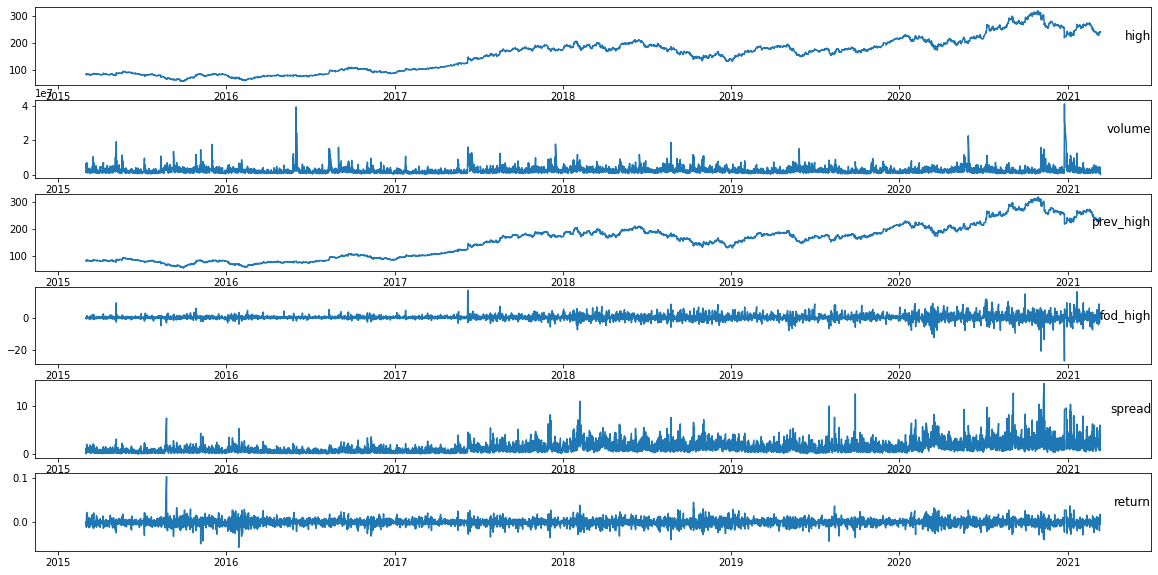

In [ ]:
# plot each column
dfplot(df)

## Preprocessing Part 2

In [ ]:
# reorder columns
col_names = ['fod_high', 'volume', 'spread', 'return']
df1 = df[col_names]

# feat_names = col_names[1:]
# tgt_name = col_names[0]

In [ ]:
# Print the first few rows
df1.head()

,fod_high,volume,spread,return
time,,,,
2015-03-02 11:00:00,-0.27,1857564.0,0.45,-0.002248
2015-03-02 12:00:00,-0.11,1561488.0,0.58,-0.001186
2015-03-02 13:00:00,-0.25,1097501.0,0.35,0.001069
2015-03-02 14:00:00,0.04,1363524.0,0.48,-0.003440
2015-03-02 15:00:00,-0.41,1110209.0,0.20,-0.001309


In [ ]:
# Print the last few rows
df1.tail()


,fod_high,volume,spread,return
time,,,,
2021-03-12 12:00:00,0.0,0.0,1.3,0.000831
2021-03-12 13:00:00,0.0,0.0,1.3,0.000831
2021-03-12 14:00:00,0.0,0.0,1.3,0.000831
2021-03-12 15:00:00,0.0,0.0,1.3,0.000831
2021-03-12 16:00:00,0.0,0.0,1.3,0.000831


In [ ]:
# We will use df instead of df1 since we only need the "high" and "volume" data

baba = df
baba.head() # create a copy|


,high,volume,prev_high,fod_high,spread,return
time,,,,,,
2015-03-02 11:00:00,84.75,1857564.0,85.02,-0.27,0.45,-0.002248
2015-03-02 12:00:00,84.64,1561488.0,84.75,-0.11,0.58,-0.001186
2015-03-02 13:00:00,84.39,1097501.0,84.64,-0.25,0.35,0.001069
2015-03-02 14:00:00,84.43,1363524.0,84.39,0.04,0.48,-0.003440
2015-03-02 15:00:00,84.02,1110209.0,84.43,-0.41,0.20,-0.001309


In [ ]:
baba.drop(['prev_high', 'fod_high', 'spread', 'return'], axis=1, inplace=True)

In [ ]:
# Double check on data
baba.head()


,high,volume
time,,
2015-03-02 11:00:00,84.75,1857564.0
2015-03-02 12:00:00,84.64,1561488.0
2015-03-02 13:00:00,84.39,1097501.0
2015-03-02 14:00:00,84.43,1363524.0
2015-03-02 15:00:00,84.02,1110209.0


In [ ]:
# Print total number of samples to split later
print(f"No. of data points: {len(baba)}")

No. of data points: 10600


For this strategy we will train the model on 1000 samples, and then trade on the next 200 samples. Let's normalize the data, and then split it into training and test data.

In [ ]:
rets = baba['high'].diff()[1:]

In [ ]:
x = np.array(rets)
x = (x - np.mean(x)) / np.std(x) # normalize

N = int(len(baba)*0.905) # 0.905 is from 2020-8-17 onwards)
P = int(len(baba)*(1-0.905))
x_train = x[-(N+P):-P]
x_test = x[-P:]

Now we're ready to train! We'll give the model a look-back window of 12 ticks since each tick is an hour

In [ ]:
theta, sharpes = train(x_train, epochs=1000, M=24, commission=0.0025, learning_rate=.01) # M is the look-back window

finished training


In order to see how well the training did, we can graph the resulting Sharpe ratio over each epoch, and hopefully see it converge to a maximum.

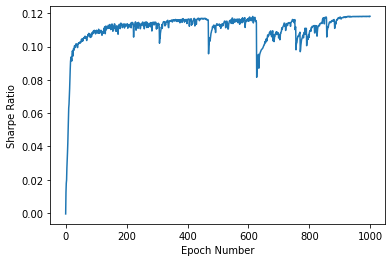

In [ ]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

From the graph above, we can identify that the optimal epoch number for the 

*   List item
*   List item

model is around 210 as it converges towards a maximum Sharpe Ratio.

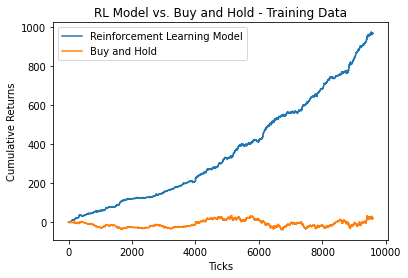

In [ ]:
train_returns = returns(positions(x_train, theta), x_train, 0.0025)
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_train.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

We can see that, over the training data, our reinforcement learning model greatly outperformed simply buying and holding the asset. Lets see how it does over the next 200 ticks, which have been held out from the model.

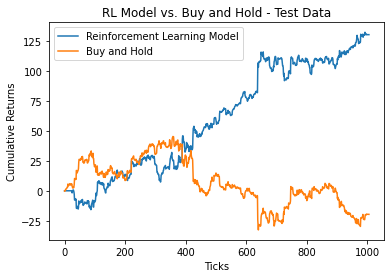

In [ ]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_test.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data");

#  Random Prints


In [ ]:
#  Print Time Period of Test Data (1000)
baba.tail(1000)



,high,volume
time,,
2020-08-17 12:00:00,255.730,1082398.0
2020-08-17 13:00:00,255.880,501119.0
2020-08-17 14:00:00,256.540,842036.0
2020-08-17 15:00:00,257.375,868092.0
2020-08-17 16:00:00,257.250,1568602.0
...,...,...
2021-03-12 12:00:00,241.720,0.0
2021-03-12 13:00:00,241.720,0.0
2021-03-12 14:00:00,241.720,0.0


## Further Improvements


1) Look-back windows are crucial in models that train on behavioral data, as notice from the test results the first 800 ticks did well due to not having periods of high volatility (covid) however when covid kicks in (at the last 200 ticks) we notice that the RL model performs poorer than a simply buy and hold mechanism 

We can consider **adjusting the look-back window** however there is some saving grace as from the last few entries of the graph (above), we can see that the RL model is learning

2) We can consider modifying the RL model to **implement Pairs Trading Strategy**. By allowing the model to have its own stop-loss mechanism this will make it more robust and reduce the loss if the RL model is unable to learn from the market pullback fast enough

*Extra Readings*
- [Optimizing the Pairs-Trading Strategy Using Deep Reinforcement Learning with Trading and Stop-Loss Boundaries](https://www.hindawi.com/journals/complexity/2019/3582516/)
- [Deep Reinforcement Learning Pairs Trading ](https://digitalcommons.usu.edu/cgi/viewcontent.cgi?article=2447&context=gradreports)